## Oscillatory Prony Embedder

The [`PronyCosineEmbedder`](../src/glefit/embedding/pronycos.py) implements a damped harmonic oscillator memory kernel

$$K(t) = \theta^2 e^{-\gamma |t|} \cos(\Omega t).$$

This embedding is defined by three parameters:

- **θ** (theta): Coupling strength (units: 1/time).
- **γ** (gamma): Damping/relaxation rate (units: 1/time). Must be positive.
- **Ω** (omega): Oscillation frequency (units: 1/time).

The corresponding drift matrix has the form:

$$
A = \begin{pmatrix}
0 & \theta & 0 \\
-\theta & \gamma & \Omega \\
0 & -\Omega & \gamma
\end{pmatrix}.
$$

The spectrum (cosine transform of the kernel) is

$$\Lambda(\omega) = \frac{\gamma \theta^2}{2} \left[ \frac{1}{\gamma^2 + (\omega - \Omega)^2} + \frac{1}{\gamma^2 + (\omega + \Omega)^2} \right].$$

interactive(children=(FloatSlider(value=1.0, description='θ:', max=3.0, min=0.1), FloatSlider(value=0.5, descr…

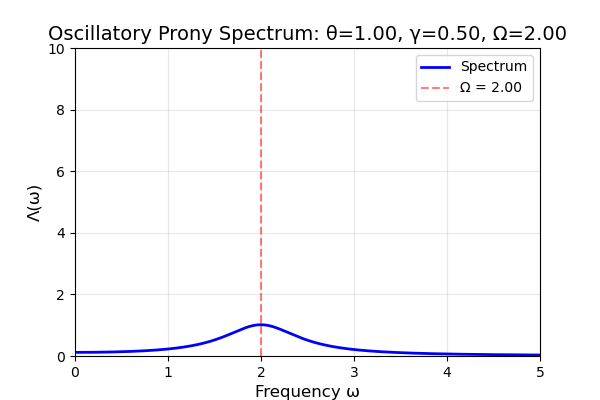

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from glefit.embedding import PronyCosineEmbedder
%matplotlib widget

# Fixed parameters
Omega_max = 5.0
freq = np.linspace(0, Omega_max, 500)

# Create figure and axes once
fig, ax = plt.subplots(figsize=(6, 4));
line, = ax.plot([], [], 'b-', linewidth=2)
vline = ax.axvline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Frequency ω', fontsize=12)
ax.set_ylabel('Λ(ω)', fontsize=12)
ax.set_xlim(0, freq[-1])
ax.set_ylim(0, 10)  # Fixed y-axis range
ax.grid(True, alpha=0.3)
legend = ax.legend(['Spectrum', 'Ω'], loc='upper right')

def plot_spectrum(theta=1.0, gamma=0.5, Omega=2.0):
    """Update the spectrum plot for given parameters."""
    # Create embedder
    emb = PronyCosineEmbedder(theta, gamma, Omega)
    
    # Compute spectrum
    spectrum = emb.spectrum(freq)
    
    # Update plot elements
    line.set_data(freq, spectrum)
    vline.set_xdata([Omega, Omega])
    ax.set_title(f'Oscillatory Prony Spectrum: θ={theta:.2f}, γ={gamma:.2f}, Ω={Omega:.2f}', fontsize=14)
    legend.get_texts()[1].set_text(f'Ω = {Omega:.2f}')
    
    fig.canvas.draw_idle()

# Interactive sliders
interact(
    plot_spectrum,
    theta=FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='θ:'),
    gamma=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='γ:'),
    Omega=FloatSlider(min=1.e-6, max=Omega_max, step=0.25, value=2.0, description='Ω:')
);

# General Two-Auxiliary-Variable Embedder
 
The [`TwoAuxEmbedder`](../src/glefit/embedding/gen2x2.py) implements a general two-auxiliary-variable memory kernel. The drift matrix is defined by five "conventional" parameters,

$$
A = \begin{pmatrix}
0 & \theta_1 & \theta_2 \\
-\theta_1 & \gamma+\delta & \Omega \\
-\theta_2 & -\Omega & \gamma-\delta
\end{pmatrix},
$$

with the corresponding memory kernel

$$K(t) = e^{-\gamma |t|} \left[ (\theta_1^2+\theta_2^2) \cosh\left(t\sqrt{\delta^2-\Omega^2}\right) - (\theta_1^2-\theta_2^2) \frac{\delta}{\sqrt{\delta^2-\Omega^2}} \sinh\left(t\sqrt{\delta^2-\Omega^2}\right) \right].$$

Internally, the embedder uses four "primitive" parameters [r, α, λ, Γ] that allow for a non-degenrate parametrisation.

- **r**: Coupling strength (units: 1/time). Must be positive.
- **α**: Asymmetry parameter (dimensionless).
- **λ**: Excess damping rate (units: 1/time). Must be positive.
- **Γ**: Frequency scale (units: 1/time). Sign determines the regime: Γ > 0 (overdamped) or Γ < 0 (underdamped).

In terms of the primitive variables, the kernel is

$$K(t) = r^2 e^{-\gamma |t|} \left[ C(\Gamma,t) - \alpha \cdot t \cdot S(\Gamma,t) \right],$$

where 

$$
\gamma = \lambda + \mathrm{max}(\Gamma, \vert\alpha\vert),$$ 

and 

$$ C(\Gamma ,t) = \begin{cases}
 \cosh(\Gamma t)  & \text{for} \quad \Gamma > 0 \\
 \cos(\Gamma t)  & \text{otherwise}
 \end{cases}
$$ 

while 

$$ S(\Gamma,t) = \begin{cases}
\frac{\sinh( \Gamma t)}{\Gamma t} & \text{for} \quad \Gamma > 0 \\
\frac{\sin( \Gamma t)}{\Gamma t} & \text{otherwise }
\end{cases}
$$

The spectrum is

$$\Lambda(\omega) = r^2 \frac{(\alpha+\gamma)\omega^2 - (\alpha-\gamma)(\gamma^2-y)}{\gamma^4 + 2\gamma^2(\omega^2-y) + (\omega^2+y)^2},$$

where y = Γ · |Γ|.


interactive(children=(FloatSlider(value=0.5, description='r:', max=1.0, min=0.1, step=0.05), FloatSlider(value…

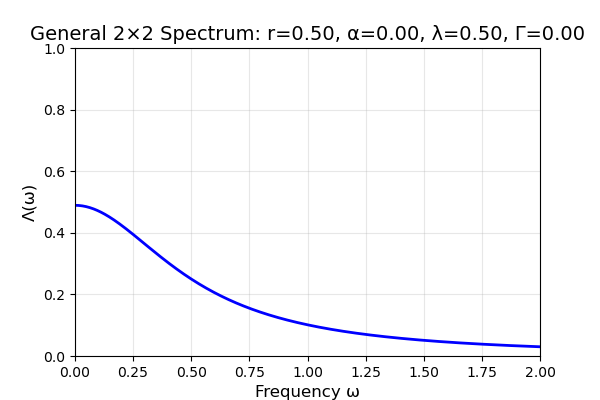

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from glefit.embedding import TwoAuxEmbedder
%matplotlib widget

# Fixed parameters
Gamma_min, Gamma_max = -2.0, 2.0
freq_max = abs(Gamma_min)
freq = np.linspace(0, 2*freq_max, 1000)

# Create figure and axes once
fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [], 'b-', linewidth=2)
ax.set_xlabel('Frequency ω', fontsize=12)
ax.set_ylabel('Λ(ω)', fontsize=12)
ax.set_xlim(0, freq_max)
ax.set_ylim(0, 1) 
ax.grid(True, alpha=0.3)

def plot_spectrum(r=0.5, alpha=0.0, lamda=0.5, Gamma=1.0):
    """Update the spectrum plot for given primitive parameters."""
    # Create embedder with dummy conventional params, then set primitives
    emb = TwoAuxEmbedder(np.array([1.0, 0.0]), 1.0, 0.0, 0.0, sigma=100.0)
    emb.primitive_params = np.array([r, alpha, lamda, Gamma])
    
    # Compute spectrum
    spectrum = emb.spectrum(freq)
    
    # Update plot elements
    line.set_data(freq, spectrum)
    ax.set_title(f'General 2×2 Spectrum: r={r:.2f}, α={alpha:.2f}, λ={lamda:.2f}, Γ={Gamma:.2f}', fontsize=14)
    
    fig.canvas.draw_idle()

# Interactive sliders
interact(
    plot_spectrum,
    r=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.5, description='r:'),
    alpha=FloatSlider(min=-2.0, max=2.0, step=0.1, value=0.0, description='α:'),
    lamda=FloatSlider(min=1.e-6, max=1.0, step=0.05, value=0.5, description='λ:'),
    Gamma=FloatSlider(min=Gamma_min, max=Gamma_max, step=0.1, value=0.0, description='Γ:')
);